# Let's figure out how to cluster to find representative motifs

With 256 audio samples, I need to a way to find a handful of motifs (5 per?) that can be used to feed find more training data and feed a simple model. At the very least, it would be useful to have several thousand motifs per species.

In [2]:
from pathlib import Path
import numpy as np

In [7]:
root = Path("../data")
motif_acafly = root / "motif/train_short_audio/acafly"

data = []
audio = []
for path in motif_acafly.glob("**/*.npy"):
    data.append(np.load(path))
    audio.append(path.as_posix().replace(".npy", ".ogg"))
data[:3]

[array([-0.03904096, -0.00558044,  0.04428169, ...,  0.00819153,
        -0.06710614,  0.10478839], dtype=float32),
 array([-0.01430092, -0.0170906 ,  0.10328198, ...,  0.01795918,
        -0.08808021, -0.01743562], dtype=float32),
 array([-0.13549505, -0.20519714,  0.05989559, ...,  0.11850143,
         0.05523453, -0.00157669], dtype=float32)]

Here's how to display multiple audio tracks in the same cell.

In [11]:
import IPython.display as ipd

for row in audio[:3]:
    print(row)
    ipd.display(ipd.Audio(row))

../data/motif/train_short_audio/acafly/XC109605/motif.0.ogg


../data/motif/train_short_audio/acafly/XC109605/motif.1.ogg


../data/motif/train_short_audio/acafly/XC11209/motif.0.ogg


## single class, svd + k-means + knn

In [27]:
import librosa

def cens_per_sec(sample_rate, target):
    """Ensure this value is a multiple of 2**6"""
    return (sample_rate // (target * (2 ** 6))) * (2 ** 6)

def chroma_cens(data, sample_rate=22050, cens_sr=10):
    return librosa.feature.chroma_cens(
        data, sample_rate, hop_length=cens_per_sec(sample_rate, cens_sr)
    )

chroma_cens(data[0]).reshape(-1).shape

(600,)

In [42]:
cens_data = [chroma_cens(row).reshape(-1) for row in data]

In [45]:
from collections import Counter
Counter([r.shape for r in cens_data])

Counter({(600,): 245, (588,): 10, (612,): 1})

In [51]:
# sigh, okay so this needs to be fixed.

def normalize(row):
    if row.shape[0] == 600:
        return row
    if row.shape[0] > 600:
        return row[:600]
    if row.shape[0] < 600:
        return np.append(row, np.zeros(600-row.shape[0]))

Counter([normalize(r).shape for r in cens_data])

Counter({(600,): 256})

In [52]:
x = np.stack([normalize(r) for r in cens_data])
x.shape

(256, 600)

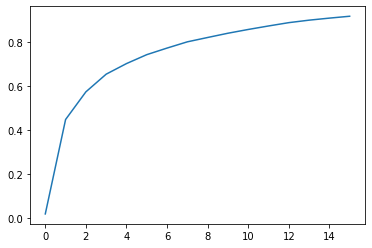

In [69]:
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt

svd = TruncatedSVD(n_components=16)
svd.fit(x)
plt.plot(svd.explained_variance_ratio_.cumsum())

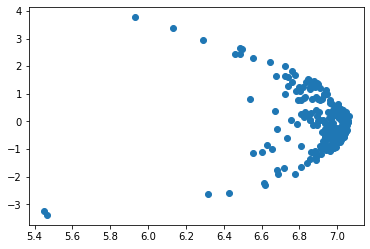

In [71]:
g = svd.transform(x)
plt.scatter(g[:, 0], g[:, 1])

In [76]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
km = kmeans.fit(g)
Counter(km.labels_)

Counter({3: 90, 1: 42, 0: 122, 2: 2})

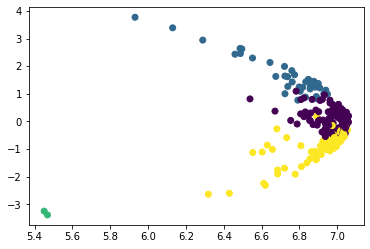

In [78]:
plt.scatter(g[:, 0], g[:, 1], c=km.labels_)

In [82]:
km.cluster_centers_

array([[ 6.97369957e+00,  1.06833796e-01, -2.87812563e-01,
        -5.49369244e-02,  3.69325259e-02, -2.96493851e-02,
        -3.13212433e-02, -2.01789206e-02, -1.18922045e-02,
         6.90607621e-03,  1.55604938e-02,  1.37645068e-02,
         1.66275544e-02, -2.67659794e-02, -5.63588826e-03,
        -3.08003518e-03],
       [ 6.73711082e+00,  1.61707784e+00,  2.56520762e-01,
         2.20351554e-01, -7.33461772e-02,  4.30996303e-02,
         5.46766755e-02, -2.08253902e-02,  6.17814532e-03,
         2.46201685e-02, -2.11786718e-02, -6.95489651e-03,
        -3.62833876e-02,  3.64845006e-02,  1.18637675e-02,
        -1.11098267e-02],
       [ 5.45928350e+00, -3.31008859e+00, -1.73499388e+00,
         2.33681853e+00,  8.01298665e-02,  5.91977002e-01,
        -7.39655528e-02, -7.91937593e-02,  3.78908898e-03,
        -1.01747761e-01, -2.22617799e-01, -7.97095651e-04,
         5.70291984e-02,  5.62595489e-02, -1.83507261e-02,
        -2.36108097e-01],
       [ 6.91920683e+00, -8.19891693e

In [91]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors().fit(g)
dist, neighbors = nn.kneighbors(km.cluster_centers_)
neighbors

array([[225, 132, 226, 227,  44],
       [170,  93, 166, 167,  92],
       [153, 152,  98,  99, 255],
       [246,  16, 228, 106,  17]], dtype=int64)

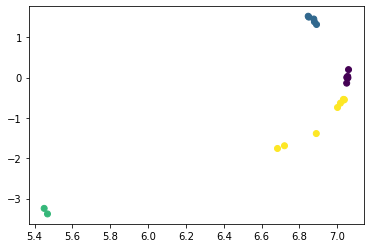

In [103]:
nn_g = g[neighbors.reshape(-1)]
plt.scatter(nn_g[:, 0], nn_g[:, 1], c=km.labels_[neighbors.reshape(-1)])

In [100]:
for label, group in enumerate(neighbors):
    print(f"nn for label {label}")
    for i in group:
        if km.labels_[i] != label:
            continue
        ipd.display(ipd.Audio(audio[i]))

nn for label 0


nn for label 1


nn for label 2


nn for label 3


## single class, spectral embedding on the knn graph
Let's try this again, but use a different embedding.

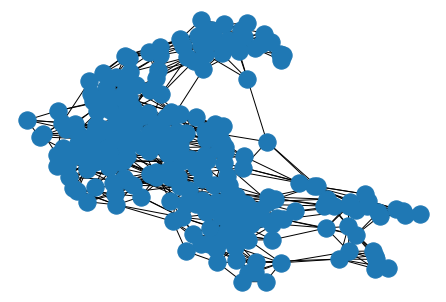

In [121]:
import networkx as nx

G = nx.from_scipy_sparse_matrix(nn.kneighbors_graph())
nx.draw(G)

In [108]:
from sklearn.manifold import spectral_embedding

emb = spectral_embedding(nn.kneighbors_graph())

c:\kaggle\birdclef-2021\venv\lib\site-packages\sklearn\utils\validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)


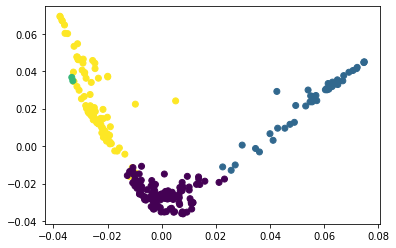

In [113]:
plt.scatter(emb[:, 0], emb[:, 1], c=km.labels_)

I'm not sure I'm having any luck here, so lets try it with a couple classes and see if there are distinct clusters in a new notebook...